Main Leaderboard

Forecaster  | Peer score against Pros | % Beat Pros on same Qs (Bootstrap) | % Beat Pros on same Qs (Resample)

Resample: Linear interpolation of two forecasters to determine "ground truth" for resampling. "Ground truth" = weighted combination of percent forecasts on each question that yields the most accurate score. Weights are 0 to 1.

Correlation: Deal with by assigning weights to questions. Weights for independent questions are 1. "Approximately correct rather than precisely wrong." Would be good to have a rule of thumb. These weights can be used for leaderboard above.

Likely want % beat Pros to be beyond 95% for significance - but obviously a sliding scale.

Can use this method for Metaculus Track Record! Have separate line for each platform - so can see significance against each platform. Then combine all competeing platforms and treat as the same forecaster going head-to-head against Metaculus!

Heroku:

Bots: https://data.heroku.com/dataclips/bmlboxtaewpwemfvqwktqxernfeq

Pros: https://data.heroku.com/dataclips/rozqhydlvqrzsllgmioruallozjx

In [2]:
# @title Import libraries
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize_scalar
from datetime import datetime
from scipy import stats

quarter = 'q4'

In [3]:
# @title Create df_bot_resolved_questions, df_pro_resolved_questions, df_pro_bot_resolved_questions, df_bot_question_weights

"""
Input question data for both bots and pros.

Only look at questions that have resolved Yes or No.

df_pro_resolved_questions: Has pro_question_id, title, resolution, scheduled_close_time
df_bot_resolved_questions: Has bot_question_id, title, resolution, scheduled_close_time

All pro questions are asked to bots, but not all bot questions are asked to pros (correction:
not true in 2024 Q4, there were some that got launched to pros first? and were bad so they
didn't get asked of bots?)

To compare pros to bots, we need to match the pro_question_id with the bot_question_id.
This is done by matching the title and scheduled_close_time.

We remove early closers from the analysis. I do this by comparing actual close time to scheduled
close time in a later cell!

df_pro_bot_resolved_questions: Has pro_question_id, bot_question_id, title, resolution, scheduled_close_time, question_weight
"""

df_bot_questions = pd.read_csv(f'scores/bots_score_data_{quarter}.csv')
df_bot_questions = df_bot_questions.rename(columns={'question_id': 'bot_question_id', 'question_title': 'title'})

df_pro_questions = pd.read_csv(f'scores/pros_score_data_{quarter}.csv')
df_pro_questions = df_pro_questions.rename(columns={'question_id': 'pro_question_id', 'question_title': 'title'})

filtered_df = df_pro_questions[df_pro_questions['resolution'].isin(['yes', 'no'])]
df_pro_resolved_questions = filtered_df[['pro_question_id', 'title', 'resolution', 'scheduled_close_time', 'actual_close_time', 'question_weight']]

filtered_df = df_bot_questions[df_bot_questions['resolution'].isin(['yes', 'no'])]
df_bot_resolved_questions = filtered_df[['bot_question_id', 'title', 'resolution', 'scheduled_close_time', 'actual_close_time', 'question_weight']]

df_pro_bot_resolved_questions = pd.merge(
    df_bot_resolved_questions,
    df_pro_resolved_questions[['pro_question_id', 'title', 'scheduled_close_time', 'question_weight']],
    on=['title', 'scheduled_close_time'],
    how='left'
)

df_pro_bot_resolved_questions['question_weight'] = df_pro_bot_resolved_questions['question_weight_x'].combine_first(df_pro_bot_resolved_questions['question_weight_y'])
df_pro_bot_resolved_questions.drop(['question_weight_x', 'question_weight_y'], axis=1, inplace=True)

# Remove duplicates
df_pro_bot_resolved_questions = df_pro_bot_resolved_questions.drop_duplicates()

# Cast both question ids to int64
df_pro_bot_resolved_questions['pro_question_id'] = df_pro_bot_resolved_questions['pro_question_id'].astype('Int64')
df_pro_bot_resolved_questions['bot_question_id'] = df_pro_bot_resolved_questions['bot_question_id'].astype('Int64')

# Remove df_bot_resolved_questions and df_pro_resolved_questions to make sure you only ever use df_pro_bot_resolved_questions
del df_bot_resolved_questions
del df_pro_resolved_questions

In [4]:
# Are any of the weights NOT 1 -- for Q3 we need to assign weights "manually," oops
print(df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['question_weight'] != 1].shape[0])

75


In [5]:
# @title Relationships between Bot Questions, create df_bot_question_related_weights (FOR Q3 ONLY)
if 25871 in df_pro_bot_resolved_questions['bot_question_id'].values:
  """
  Relationships between questions are entered as tuples. These relationships
  will be used to perform logical consistency checks.

  Weights are assigned to questions based on relationships. This is a way to
  deal with correlations between questions.
  """

  # Scope sensitity list of tuples where the first entry should equal the sum of the others
  bot_scope_questions = [
        (26019, 26017, 26018), # Starship launches
        (26098, 26096, 26097), # SENSEX
        (26159, 26158, 26157), # Geomagnetic storm July 28
        (26194, 26195, 26196), # measles cases
        (26006, 26005, 26004), # Trump lead over Biden
        (26642, 26643, 26644), # spanish wikipedia
        (26700, 26701, 26702), # market cap cryptocurrencies
        (27261, 27262, 27263), # Geomagnetic storm Sept 11
        ]

  # Sum of each tuple should logically equal 1
  bot_sum_to_1_questions = [
      (25952, 25953, 25954), # French PM party July 30
      (25957, 25958, 25959), # Tour de France winner
      (26570, 26571, 26572, 26573), # Warhammer
      (26574, 26575, 26576, 26577), # H5 cases in US
      (26671, 26670, 26669), # DOES NOT SUM TO EXACTLY 1 PM France Aug 31
      (27748, 27747, 27746, 27749), # Speed Chess
      (27488, 27489, 27490, 27491, 27492, 27493), # August CPI
      (27932, 27933, 27934, 27935), # Chinese youth unemployment
      (27484, 27485, 27486, 27487), # Fed rate cut Sept meeting
      (28045, 28044, 28043, 28042), # Afd vote share
      (28038, 28039, 28040, 28041), # Major Atlantic hurricanes
      (26776, 26777, 26778, 26779), # Seattle-Tacoma-Bellevu Air Quality
      ]

  # parent, child, if_yes, if_no
  bot_conditional_pair = [
      (26917, 26918, 26919, 26920) # israel lebanon conflict
  ]

  # CDFs - Logically the probability of each successive question must not decrease
  bot_increasing_questions = [
      (26981, 26982, 26983, 26984, 26985, 26986), # aircraft ADIZ
      (26977, 26978, 26979, 26980), # hurricane energy
      (27548, 27547, 27546, 27545), # mpox CDC risk level
      (28306, 28305, 28304, 28303, 28302), # Gas prices in US Sept 30
  ]

  bot_repeated_questions = [
      (26646, 26021), # mens 100m dash record
      (26555, 27021), # USA gold silver
      (26210, 26917), # israel invade lebanon
      (26781, 26304), # ruto
      (26100, 27136), # rfk drop out
      (25956, 27158), # democrat brokered convention
      (26102, 27022), # astronauts NOT EXACT REPEAT
      (26022, 27085), # arrest warrants NOT EXACT REPEAT
      (26235, 27281), # Buffett Indicator
      (26390, 27789), # Bubble Magnificent 7
      (26024, 27161), # QB Bo Nix starting for Broncos
      (26302, 27282), # riots
      (25955, 27157), # armed forces death US, China, Japan
      (26958, 27640), # Youtube banned in Russia
      (25936, 27141), # Crimean bridge attack
  ]

  bot_similar_questions = [
      (26915, 26916), # harris favorability
      (26913, 26914), # trump favorability
      (26193, 27733), # debate on Sept 10
      (27886, 27968), # Taylor Swift awards
      (27723, 27637), # Best Rock VMAs
      (27583, 27582, 27584, 27602, 27603, 27604), # mpox Zambia, US, Angola, Russia, Japan, Mexico
      (26306, 26838), # Richest people 250th > $10.2, 500th > 6.2
      (27887, 27969), # Emmys Outstanding Limited or Anthology Series
      (28206, 28207, 28208, 28209, 28210), # LMSYS leaderboard
      (28154, 28336), # Nigeria Edo gubernatorial election
      (26407, 27897), # Second Russian mobilization wave
      (27539, 26215), # Nuclear weapons used
      (27606, 27607, 27608, 27609, 27610), # Ukranian forces capture
      (26387, 27788), # Will Tesla increase deliveries in Q3 2024
      (26821, 26959), # VP debate
      (26212, 26213, 26214), # number of dairy cow herds with H5N1
      (26639, 26640, 26641), # Presidential debate 0, 1, or 2+
  ]

  ####### CREATE QUESTION WEIGHTS #########

  # Combine both lists of tuples
  all_questions = bot_scope_questions + bot_sum_to_1_questions + bot_increasing_questions + bot_similar_questions + bot_conditional_pair

  # Create an empty list to store the data
  data = []

  # Process each tuple
  for tuple_questions in all_questions:
      # Calculate the weight for each question in the tuple
      weight = np.log2(1 + len(tuple_questions))/(1 + len(tuple_questions))

      # Add each question and its weight to the data list
      for question_id in tuple_questions:
          data.append({'bot_question_id': question_id, 'question_weight': weight})

  # Process each tuple
  for tuple_questions in bot_repeated_questions:
      # 1st iteration has weight 1, 2nd has weight 1/2, 3rd weight 1/3....
      count = 1

      # Add each question and its weight to the data list
      for question_id in tuple_questions:
          data.append({'bot_question_id': question_id, 'question_weight': 1/count})
          count += 1

  # Create the DataFrame
  df = pd.DataFrame(data)

  # Sort the DataFrame by bot_question_id for better readability
  df_bot_question_related_weights = df.sort_values('bot_question_id').reset_index(drop=True)

# if df_bot_question_related_weights is defined, replace the question weights in df_pro_bot_resolved_questions
if 'df_bot_question_related_weights' in locals():
    df_pro_bot_resolved_questions = pd.merge(
        df_pro_bot_resolved_questions,
        df_bot_question_related_weights,
        on='bot_question_id',
        how='left'
    )

    df_pro_bot_resolved_questions['question_weight'] = df_pro_bot_resolved_questions['question_weight_y'].combine_first(df_pro_bot_resolved_questions['question_weight_x'])
    df_pro_bot_resolved_questions.drop(['question_weight_x', 'question_weight_y'], axis=1, inplace=True)

In [6]:
# Are there any non-1 weights (there should be)
print(df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['question_weight'] != 1].shape[0])

75


In [7]:
# Unique pro questions, bot questions
pro_questions = df_pro_bot_resolved_questions['pro_question_id'].unique()
bot_questions = df_pro_bot_resolved_questions['bot_question_id'].unique()
print(pro_questions, bot_questions)

<IntegerArray>
[ <NA>, 28943, 28944, 28973, 29053, 29181, 29215, 29216, 29270, 29271, 29275,
 29278, 29476, 29528, 29529, 29530, 29531, 29532, 29533, 29534, 29679, 29680,
 29681, 29734, 29736, 29786, 29862, 29863, 30131, 30168, 30508, 30548, 30549,
 30550, 30645]
Length: 35, dtype: Int64 <IntegerArray>
[28857, 28933, 28935, 28936, 28937, 28959, 28960, 28985, 28986, 28987,
 ...
 30532, 30534, 30577, 30578, 30579, 30586, 30637, 30638, 30724, 30726]
Length: 183, dtype: Int64


In [8]:
df_pro_bot_resolved_questions.dtypes

bot_question_id           Int64
title                    object
resolution               object
scheduled_close_time     object
actual_close_time        object
pro_question_id           Int64
question_weight         float64
dtype: object

In [9]:
# Remove early closers IF right now is before scheduled close time
df_pro_bot_resolved_questions['scheduled_close_time'] = pd.to_datetime(df_pro_bot_resolved_questions['scheduled_close_time']).dt.tz_localize(None)
df_pro_bot_resolved_questions['actual_close_time'] = pd.to_datetime(df_pro_bot_resolved_questions['actual_close_time']).dt.tz_localize(None)

In [10]:
remove_early_closers = True # SET TO FALSE WHEN ALL Q'S ARE RESOLVED
if remove_early_closers:
  df_pro_bot_resolved_questions = df_pro_bot_resolved_questions[(df_pro_bot_resolved_questions['actual_close_time'] <= df_pro_bot_resolved_questions['scheduled_close_time'])]

print('Number of unique questions in df_pro_bot_resolved_questions:', len(df_pro_bot_resolved_questions['bot_question_id']))

Number of unique questions in df_pro_bot_resolved_questions: 183


In [11]:
# Step 1: Read in the scores dataclips from heroku, take last (spot) score for each question_id, forecaster pair; make it into what Tom's code expects

## BOTS

df_bot_scores = pd.read_csv(f'scores/bots_score_data_{quarter}.csv')
# IMPORTANT: ONLY KEEP THE QUESTIONS IN DF_PRO_BOT_RESOLVED_QUESTIONS
df_bot_scores = df_bot_scores[df_bot_scores['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]

# BASELINE
df_bot_baseline = df_bot_scores[df_bot_scores['score_type'] == 'spot_baseline']

# Take the LAST score for each (forecaster, question_id) pair
df_bot_baseline = df_bot_baseline.groupby(['question_id', 'forecaster']).last().reset_index()

# PEER
df_bot_peer = df_bot_scores[df_bot_scores['score_type'] == 'spot_peer']

# Take the LAST score for each (forecaster, question_id) pair
df_bot_peer = df_bot_peer.groupby(['question_id', 'forecaster']).last().reset_index()

## PROS

df_pro_scores = pd.read_csv(f'scores/pros_score_data_{quarter}.csv')
# IMPORTANT: ONLY KEEP THE QUESTIONS IN DF_PRO_BOT_RESOLVED_QUESTIONS
df_pro_scores = df_pro_scores[df_pro_scores['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]

# BASELINE
df_pro_baseline = df_pro_scores[df_pro_scores['score_type'] == 'spot_baseline']

# Take the LAST score for each (forecaster, question_id) pair
df_pro_baseline = df_pro_baseline.groupby(['question_id', 'forecaster']).last().reset_index()
df_pro_baseline_long = df_pro_baseline.copy()

# ADD THE BOT MEDIAN SPOT SCORE & REMOVE UNNECESSARY COLUMNS
df_bot_baseline = df_bot_baseline[['question_id', 'question_title', 'question_weight', 'forecaster', 'score', 'resolution']]

# Calculate medians and preserve metadata
medians = (df_bot_baseline
    .groupby(['question_id', 'question_title', 'question_weight'])['score']
    .median()
    .reset_index()
    .assign(forecaster='bot_median')
)

# Combine with original data
df_bot_baseline = pd.concat([df_bot_baseline, medians])
df_bot_baseline_long = df_bot_baseline.copy()

# DO THE SAME FOR DF_BOT_PEER
df_bot_peer = df_bot_peer[['question_id', 'question_title', 'question_weight', 'forecaster', 'score', 'resolution']]

# Get all columns except score and forecaster (TK: Does it make sense to take median of peer scores?)
medians = (df_bot_peer
    .groupby(['question_id', 'question_title', 'question_weight'])['score']
    .median()
    .reset_index()
    .assign(forecaster='bot_median')
)

# Combine with original data
df_bot_peer = pd.concat([df_bot_peer, medians])

df_bot_baseline_long.head()

,question_id,question_title,question_weight,forecaster,score,resolution
0,28857,Will Tim Walz cease to be Kamala Harriss's run...,1.0,000_bot,92.599942,no
1,28857,Will Tim Walz cease to be Kamala Harriss's run...,1.0,Bot_Pepa,94.710505,no
2,28857,Will Tim Walz cease to be Kamala Harriss's run...,1.0,Cassie,98.719957,no
3,28857,Will Tim Walz cease to be Kamala Harriss's run...,1.0,GreeneiBot2,89.012238,no
4,28857,Will Tim Walz cease to be Kamala Harriss's run...,1.0,HSeldon,92.599942,no


In [12]:
# Step 2: FILTER TO ONLY THOSE QUESTION ID's THAT ARE IN DF_PRO_BOT_RESOLVED_QUESTIONS
df_bot_peer = df_bot_peer[df_bot_peer['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_bot_baseline = df_bot_baseline[df_bot_baseline['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_bot_baseline_long = df_bot_baseline_long[df_bot_baseline_long['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_pro_baseline = df_pro_baseline[df_pro_baseline['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]
df_pro_baseline_long = df_pro_baseline_long[df_pro_baseline_long['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]
df_bot_scores = df_bot_scores[df_bot_scores['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_pro_scores = df_pro_scores[df_pro_scores['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]

In [13]:
all_bots = df_bot_peer['forecaster'].unique()
all_bots

array(['000_bot', 'Bot_Pepa', 'Cassie', 'GreeneiBot2', 'HSeldon',
       'Jay_Bailey_Bot', 'MWG', 'RonanMcGovern', 'SeidrBot', 'acm_bot',
       'bestworldbot', 'biak_bot', 'centobot', 'christian+botOct17',
       'histerio', 'jkraybill_bot', 'karamazov', 'mf-bot-1', 'mf-bot-2',
       'mf-bot-3', 'mf-bot-4', 'pgodzinai', 'silicoqr', 'tombot37',
       'tombot47', 'tombot61', 'InstitutPelFutur', 'RyansAGI',
       'SynapseSeer', 'VeritasAI', 'annabot', 'archipelago', 'estr.ai',
       'lostandfound', 'twsummerbot', 'HunchexBot', 'Panshul42',
       'SaraBase', 'Unwrapped80T', 'mmBot', 'gnosis-ai', 'manticAI',
       'lookahead', 'mf-bot-5', 'predictomatic', 'Grizeu_Bot', 'hlb-bot',
       'ProfessorSP', 'bot_median'], dtype=object)

In [14]:
# Unique score_type in df_bot_scores
df_bot_scores['score_type'].unique()

array(['relative_legacy', 'peer', 'baseline', 'spot_peer',
       'spot_baseline'], dtype=object)

In [15]:
def calculate_weighted_stats(df):
    results = []

    # For each forecaster
    for forecaster in df['forecaster'].unique():
        forecaster_data = df[df['forecaster'] == forecaster]

        # Get scores and weights
        scores = forecaster_data['score']
        weights = forecaster_data['question_weight']

        # Calculate weighted mean
        weighted_mean = np.average(scores, weights=weights)
        weighted_sum = np.sum(scores * weights)

        # Calculate weighted standard error
        # Using weighted variance formula
        weighted_var = np.average((scores - weighted_mean)**2, weights=weights)
        n = len(scores)
        weighted_se = np.sqrt(weighted_var / n)

        # Calculate t-statistic for 95% confidence interval
        t_value = stats.t.ppf(0.975, n-1)
        ci_lower = weighted_mean - (t_value * weighted_se)

        results.append({
            'forecaster': forecaster,
            'weighted_mean': weighted_mean,
            'weighted_sum': weighted_sum,
            'n_questions': n,
            'ci_lower': ci_lower,
            'weighted_se': weighted_se
        })

    # Convert to dataframe and sort by lower bound
    results_df = pd.DataFrame(results)
    return results_df.sort_values('weighted_sum', ascending=False)

# Calculate and show results
ranked_forecasters = calculate_weighted_stats(df_bot_peer)

ranked_forecasters.head(10)

,forecaster,weighted_mean,weighted_sum,n_questions,ci_lower,weighted_se
48,bot_median,9.940221,1405.884910,182,8.184107,0.890002
14,histerio,9.028709,1276.966133,182,4.296726,2.398179
3,GreeneiBot2,8.931071,1263.156709,182,4.234784,2.380088
21,pgodzinai,7.765041,1098.240595,182,1.878935,2.983091
39,mmBot,7.895325,1077.190466,177,2.709216,2.627828
30,annabot,7.516718,916.543263,158,3.779524,1.892069
41,manticAI,6.843660,891.591807,168,1.800177,2.554605
20,mf-bot-4,5.780574,817.569453,182,-1.123459,3.498978
10,bestworldbot,5.697943,757.450202,172,-0.381698,3.079962
43,mf-bot-5,5.439200,620.685009,145,-1.128973,3.323007


In [16]:
# @title Create df_bot_baseline, df_bot_peer, df_bot_forecasts, bots

"""
df_bot_baseline: Spot Baseline scores for all bots & bot_median

df_bot_peer: Spot Peer scores for all bots & bot_median. Can be used to recreate
the tournament leaderboard on the site.

df_bot_forecasts: Spot forecasts for all bots & bot_median, ie only counts the
final forecast

bots: a list of all bots
"""

# Pivot df_bot_baseline
df_bot_baseline = df_bot_baseline.rename(columns={'question_id': 'bot_question_id'})
#df_bot_baseline['score'] = pd.to_numeric(df_bot_baseline['score'], errors='coerce')
df_pivoted = df_bot_baseline.pivot(index='bot_question_id', columns='forecaster', values='score')
df_pivoted = df_pivoted.reset_index()
df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

# Move 'question_id' to be the first column
cols = df_pivoted.columns.tolist()
cols = ['bot_question_id'] + [col for col in cols if col != 'bot_question_id']
df_pivoted = df_pivoted[cols]

all_columns = df_pivoted.columns.tolist()
# Remove 'question_id' and 'bot_median' from the list if they exist
all_columns = [col for col in all_columns if col not in ['bot_question_id', 'bot_median']]
new_column_order = ['bot_question_id', 'bot_median'] + all_columns
df_pivoted = df_pivoted[new_column_order]
df_bot_baseline_wide = df_pivoted
df_bot_baseline_wide['bot_question_id'] = pd.to_numeric(df_bot_baseline_wide['bot_question_id'], errors='coerce')

# Create df_bot_peer
df_bot_peer = df_bot_peer.rename(columns={'question_id': 'bot_question_id'})
df_bot_peer['score'] = pd.to_numeric(df_bot_peer['score'], errors='coerce')


def make_wide(df_bot_peer):
  df_pivoted = df_bot_peer.pivot(index='bot_question_id', columns='forecaster', values='score')
  df_pivoted = df_pivoted.reset_index()
  df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

  # Step 4: Move 'question_id' to be the first column
  cols = df_pivoted.columns.tolist()
  cols = ['bot_question_id'] + [col for col in cols if col != 'bot_question_id']
  df_pivoted = df_pivoted[cols]

  all_columns = df_pivoted.columns.tolist()
  ## Remove 'question_id' and 'bot_median' from the list if they exist
  all_columns = [col for col in all_columns if col not in ['bot_question_id']]
  new_column_order = ['bot_question_id'] + all_columns
  df_pivoted = df_pivoted[new_column_order]
  df_bot_peer_wide = df_pivoted
  df_bot_peer_wide['bot_question_id'] = pd.to_numeric(df_bot_peer_wide['bot_question_id'], errors='coerce')

  # Join with df_pro_bot_resolved_questions to get question weights
  df_bot_peer_wide = pd.merge(
      df_bot_peer_wide,
      df_pro_bot_resolved_questions[['bot_question_id', 'question_weight']],
      on='bot_question_id',
      how='left'
  )

  return df_bot_peer_wide

df_bot_peer_wide = make_wide(df_bot_peer)


In [17]:
################ CONVERT BASELINE SCORE TO FORECAST ###################

def convert_baseline_to_forecasts(df):
    # Assumes columns: 'bot_question_id' 'resolution'
    result_df = df.copy()

    def score_to_forecast(score, resolution):
        if resolution == 'yes':
            return 2 ** (score/100 - 1)
        else:
            return 1 - 2 ** (score/100 - 1)

    score_columns = ['score']
    #score_columns = [col for col in score_columns if col not in ['bot_question_id', 'resolution', 'pro_question_id']]

    for col in score_columns:
        result_df['forecast'] = result_df.apply(lambda row: score_to_forecast(row[col], row['resolution']), axis=1)

    return result_df

#df_temp = pd.merge(
    #df_bot_baseline,
    #df_bot_resolved_questions[['bot_question_id', 'resolution']],
    #on='bot_question_id',
    #how='left'
#)

df_bot_forecasts = convert_baseline_to_forecasts(df_bot_baseline)
df_bot_forecasts = df_bot_forecasts.drop('resolution', axis=1)

#print(f"Shape of df_bot_forecasts: {df_bot_forecasts.shape}")
#print(df_bot_forecasts.columns)

df_bot_forecasts.head()

,bot_question_id,question_title,question_weight,forecaster,score,forecast
0,28857,Will Tim Walz cease to be Kamala Harriss's run...,1.0,000_bot,92.599942,0.050000
1,28857,Will Tim Walz cease to be Kamala Harriss's run...,1.0,Bot_Pepa,94.710505,0.036000
2,28857,Will Tim Walz cease to be Kamala Harriss's run...,1.0,Cassie,98.719957,0.008833
3,28857,Will Tim Walz cease to be Kamala Harriss's run...,1.0,GreeneiBot2,89.012238,0.073333
4,28857,Will Tim Walz cease to be Kamala Harriss's run...,1.0,HSeldon,92.599942,0.050000


In [18]:
# @title Bot Baseline Leaderboard

# Calculate the total score for each bot
total_scores = df_bot_baseline_wide.iloc[:, 1:].fillna(0).sum()

# Create a new dataframe with the total scores
df_total_scores = pd.DataFrame({'Bot': total_scores.index, 'Baseline_Score': total_scores.values})

# Sort the dataframe by Total_Score in descending order
df_total_scores_sorted = df_total_scores.sort_values('Baseline_Score', ascending=False)

# Add a Rank column
df_total_scores_sorted['Rank'] = range(1, len(df_total_scores_sorted) + 1)

# Set Rank as the index
df_total_scores_ranked = df_total_scores_sorted.set_index('Rank')

# Display the result
df_total_scores_ranked

,Bot,Baseline_Score
Rank,,
1,histerio,2630.796796
2,bot_median,2585.553199
3,GreeneiBot2,2544.768193
4,pgodzinai,2355.064634
5,manticAI,2072.197852
6,mmBot,1970.231100
7,mf-bot-4,1410.145707
8,annabot,1256.077460
9,bestworldbot,1028.722572


In [19]:
# @title Bot Peer Leaderboard

"""
NOTE: This can be different from the leaderboad on the site IF early closers
are excluded (check remove_early_closers bool).
"""

df_filled = df_bot_peer_wide.fillna(0)
#df_filled = df_filled.drop(['bot_question_id', 'question_weight'], axis=1)

# Calculate the total score for each player
total_scores = df_filled.sum()

# Create a new DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'bot': total_scores.index,
    'Peer Score': total_scores.values
})

# Remove bot_question_id from the leaderboard
leaderboard = leaderboard[leaderboard['bot'] != 'bot_question_id']

# Sort the leaderboard by Total Score in descending order
leaderboard = leaderboard.sort_values('Peer Score', ascending=False)

# Reset the index and add a 'Rank' column
leaderboard = leaderboard.reset_index(drop=True)
leaderboard.index += 1
leaderboard.index.name = 'Rank'

# Display the leaderboard
leaderboard

,bot,Peer Score
Rank,,
1,histerio,1899.164595
2,bot_median,1840.974641
3,GreeneiBot2,1821.600114
4,pgodzinai,1692.222052
5,mmBot,1425.130126
6,manticAI,1377.193432
7,annabot,1291.269846
8,bestworldbot,1010.902036
9,mf-bot-4,994.225533


In [20]:
# ADD PRO_MEDIAN ROWS

df_pro_scores = df_pro_baseline

# Create pro_median: for each question, calculate the median score
median_scores = df_pro_scores.groupby('question_id')['score'].median().reset_index()
median_scores = median_scores.rename(columns={'score': 'median_score'})  # rename to avoid confusion

# Create template rows with metadata
template_rows = df_pro_scores.groupby('question_id').first().reset_index()

# Create new rows with median scores
median_rows = template_rows.merge(median_scores, on='question_id', how='left')
median_rows['forecaster'] = 'pro_median'
median_rows['score'] = median_rows['median_score']  # assign the median to score column
median_rows = median_rows.drop('median_score', axis=1)  # clean up temporary column

# Concatenate original DataFrame with new median rows
df_combined = pd.concat([df_pro_scores, median_rows], ignore_index=True)

df_pro_scores = df_combined

df_combined.tail()

,question_id,forecaster,question_title,created_at,user_id,score,score_type,resolution,scheduled_close_time,actual_close_time,question_weight,post_id
338,30508,pro_median,Will Ghana declare a winner in its presidentia...,2024-12-04 14:28:10.74262+00,101465,71.369581,spot_baseline,yes,2024-12-06 15:30:00+00,2024-12-06 15:30:00+00,1.0,30747
339,30548,pro_median,Will Joe Biden sign 2 or more executive orders...,2024-12-05 14:29:40.263228+00,101465,28.688115,spot_baseline,yes,2024-12-07 15:30:00+00,2024-12-07 15:30:00+00,1.0,30794
340,30549,pro_median,Will Joe Biden sign 3 or more executive orders...,2024-12-05 14:29:40.283537+00,101465,-73.696559,spot_baseline,yes,2024-12-07 15:30:00+00,2024-12-07 15:30:00+00,1.0,30795
341,30550,pro_median,Will Joe Biden sign 4 or more executive orders...,2024-12-05 14:29:40.303279+00,101465,-232.192809,spot_baseline,yes,2024-12-07 15:30:00+00,2024-12-07 15:30:00+00,1.0,30796
342,30645,pro_median,Will the domestic opening weekend box office r...,2024-12-10 14:23:42.811773+00,101465,84.799691,spot_baseline,no,2024-12-12 15:30:00+00,2024-12-12 15:30:00+00,1.0,30915


In [21]:
df_bot_scores = df_bot_scores[df_bot_scores['score_type'] == 'spot_baseline']

In [22]:
# @title Create df_pro_baseline, df_pro_forecasts

"""
WARNING: This may not exclude early closers.

df_pro_baseline: Spot Baseline scoes for all pros & pro_median

df_pro_forecasts: Spot forecasts for all pros & pro_median
"""

# Pivot df_pro_scores (baseline)
#df_pro_scores = df_pro_scores.rename(columns={'question_id': 'pro_question_id'})
#df_pivoted = df_pro_scores.pivot(index='pro_question_id', columns='forecaster', values='score')
#df_pivoted = df_pivoted.reset_index()
#df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

#cols = df_pivoted.columns.tolist()
#cols = ['pro_question_id'] + [col for col in cols if col != 'pro_question_id']
#df_pivoted = df_pivoted[cols]

#all_columns = df_pivoted.columns.tolist()
#all_columns = [col for col in all_columns if col not in ['pro_question_id', 'pro_median']]
#new_column_order = ['pro_question_id', 'pro_median'] + all_columns
#df_pivoted = df_pivoted[new_column_order]
#df_pro_baseline = df_pivoted
#df_pro_baseline['pro_question_id'] = pd.to_numeric(df_pro_baseline['pro_question_id'], errors='coerce')


#print(f"Shape of df_pro_baseline: {df_pro_baseline.shape}")
#print(df_pro_baseline.columns)


#df_temp = pd.merge(
    #df_pro_baseline,
    #df_pro_scores[['pro_question_id', 'resolution']],
    #on='pro_question_id',
    #how='left'
#)

df_pro_forecasts = convert_baseline_to_forecasts(df_pro_scores)
df_pro_forecasts = df_pro_forecasts.drop('resolution', axis=1)

df_pro_forecasts.head()

#print(f"Shape of df_pro_forecasts: {df_pro_forecasts.shape}")
#print(df_pro_forecasts.columns)


,question_id,forecaster,question_title,created_at,user_id,score,score_type,scheduled_close_time,actual_close_time,question_weight,post_id,forecast
0,28943,Jgalt,Will the Liberal Democratic Party win a majori...,2024-10-21 14:17:29.643258+00,101465,-47.393119,spot_baseline,2024-10-23 14:30:00+00,2024-10-23 14:30:00+00,1.0,29018,0.64
1,28943,MaciekK,Will the Liberal Democratic Party win a majori...,2024-10-21 14:17:29.643258+00,117580,26.303441,spot_baseline,2024-10-23 14:30:00+00,2024-10-23 14:30:00+00,1.0,29018,0.40
2,28943,OpenSystem,Will the Liberal Democratic Party win a majori...,2024-10-21 14:17:29.643258+00,120160,0.000000,spot_baseline,2024-10-23 14:30:00+00,2024-10-23 14:30:00+00,1.0,29018,0.50
3,28943,Sergio,Will the Liberal Democratic Party win a majori...,2024-10-21 14:17:29.643258+00,115725,-15.200309,spot_baseline,2024-10-23 14:30:00+00,2024-10-23 14:30:00+00,1.0,29018,0.55
4,28943,Zaldath,Will the Liberal Democratic Party win a majori...,2024-10-21 14:17:29.643258+00,139161,-32.192809,spot_baseline,2024-10-23 14:30:00+00,2024-10-23 14:30:00+00,1.0,29018,0.60


In [23]:
# @title Create df_pro_bot_forecasts, df_bot_vs_pro_peer, df_bot_vs_pro_leaderboard, df_bot_vs_pro_weighted_leaderboard

"""
df_pro_bot_forecasts: Spot forecasts for all bots & pro_median, question resolutions, and question weights

df_bot_vs_pro_peer: Calculates Peer scores as if there is a tournament with only
a single bot and the pro_median. This is the main comparison metric for
assessing how a bot compares to the human aggregate. Positive scores mean that
the bot did better than the pro_median. Negative scores mean that the bot did
worse than the pro_median.

df_bot_vs_pro_leaderboard: A leaderboard based on df_bot_vs_pro_peer.

df_bot_vs_pro_weighted_leaderboard: A leaderboard based on df_bot_vs_pro_peer
with question weighting.
"""

# Now pivot df_pro_forecasts; forecaster = columns; forecast = values; index = pro_question_id
df_pro_forecasts = df_pro_forecasts.rename(columns={'question_id': 'pro_question_id'})
df_pro_forecasts = df_pro_forecasts.pivot(index='pro_question_id', columns='forecaster', values='forecast')
# Make the index a column and make it numeric
df_pro_forecasts = df_pro_forecasts.reset_index()

# Now pivot df_bot_forecasts; forecaster = columns; forecast = values; index = pro_question_id
df_bot_forecasts = df_bot_forecasts.rename(columns={'question_id': 'bot_question_id'})
df_bot_forecasts = df_bot_forecasts.pivot(index='bot_question_id', columns='forecaster', values='forecast')
# Make the index a column and make it numeric
df_bot_forecasts = df_bot_forecasts.reset_index()

# One row per question, with pro_question_id and bot_question_id and resolution
df_pro_bot_resolved_questions_first = df_pro_bot_resolved_questions.groupby(['pro_question_id', 'bot_question_id']).first().reset_index()[['pro_question_id', 'bot_question_id', 'resolution', 'question_weight']]

df2 = pd.merge(
    df_pro_bot_resolved_questions_first,
    df_pro_forecasts[['pro_question_id', 'pro_median']],
    on='pro_question_id',
    how='left'
)

df_pro_bot_forecasts = pd.merge(
    df2,
    df_bot_forecasts,
    on='bot_question_id',
    how='left'
)

df_pro_bot_forecasts.tail()

,pro_question_id,bot_question_id,resolution,question_weight,pro_median,000_bot,Bot_Pepa,Cassie,GreeneiBot2,Grizeu_Bot,...,mf-bot-4,mf-bot-5,mmBot,pgodzinai,predictomatic,silicoqr,tombot37,tombot47,tombot61,twsummerbot
29,30508,30532,yes,1.0,0.82,0.900,0.92,0.900000,0.828,0.89,...,0.95,0.90,0.80,0.89,NaN,NaN,NaN,NaN,NaN,0.743
30,30548,30577,yes,0.5,0.61,0.325,0.30,0.716667,0.798,0.65,...,0.65,0.55,0.75,0.69,NaN,NaN,NaN,NaN,NaN,0.822
31,30549,30578,yes,0.5,0.30,0.300,0.19,0.725000,0.660,0.65,...,0.40,0.35,0.65,0.38,NaN,NaN,NaN,NaN,NaN,0.662
32,30550,30579,yes,0.5,0.10,0.200,0.26,0.558333,0.452,0.25,...,0.60,0.25,0.50,0.16,NaN,NaN,NaN,NaN,NaN,0.820
33,30645,30724,no,1.0,0.10,0.100,0.14,0.262500,0.214,NaN,...,0.20,0.15,0.35,0.22,NaN,NaN,NaN,NaN,NaN,0.482


In [24]:
#print(f"Shape of df_pro_bot_forecasts: {df_pro_bot_forecasts.shape}")
#print(df_pro_bot_forecasts.columns)

# Create a new DataFrame to store peer scores
df_bot_vs_pro_peer = df_pro_bot_forecasts.copy()
df_bot_vs_pro_peer = df_bot_vs_pro_peer[['pro_median', 'resolution', 'question_weight', 'bot_question_id']]

# Calculate peer score for each bot
for bot in all_bots:
    # Calculate Head-to-head score based on the condition
    peer_score = np.where(
        df_pro_bot_forecasts['resolution'] == 1,
        np.log(df_pro_bot_forecasts[bot] / df_pro_bot_forecasts['pro_median']),
        np.log((1 - df_pro_bot_forecasts[bot]) / (1 - df_pro_bot_forecasts['pro_median']))
    )

    # Add the calculated peer score to the new DataFrame
    df_bot_vs_pro_peer[bot] = 100 * peer_score

# Calculate Head-to-head score for bot_team
peer_score = np.where(
    df_pro_bot_forecasts['resolution'] == 1,
    np.log(df_pro_bot_forecasts['bot_median'] / df_pro_bot_forecasts['pro_median']),
    np.log((1 - df_pro_bot_forecasts['bot_median']) / (1 - df_pro_bot_forecasts['pro_median']))
)

# Add the calculated peer score to the new DataFrame
df_bot_vs_pro_peer["bot_team_median"] = 100 * peer_score

In [25]:
total_scores = df_bot_vs_pro_peer.sum(axis=0)
# remove resolution, question_weight, bot_question_id from total scores
total_scores = total_scores.drop(['resolution', 'question_weight', 'bot_question_id'])

# First pivot to long format - each row will be a question-forecaster pair
df_long = df_bot_vs_pro_peer.melt(
    id_vars=['bot_question_id', 'question_weight', 'resolution'],
    var_name='forecaster',
    value_name='score'
)

# Drop any rows where score is NaN
df_long = df_long.dropna(subset=['score'])

# Cast question_weight as numeric
df_long['question_weight'] = pd.to_numeric(df_long['question_weight'], errors='coerce')

# Group first, then do the multiplication and sum
weighted_scores = df_long.groupby('forecaster').apply(lambda x: (x['score'] * x['question_weight']).sum(axis=0))

# Calculate number of questions answered by each bot
num_questions = df_long.groupby('forecaster')['bot_question_id'].nunique()
#num_weighted_questions = df_bot_vs_pro_peer.mul(df_pro_bot_forecasts['question_weight'], axis=0).apply(lambda col: col[col.notna() & col.apply(np.isreal)].count())

# Create a new DataFrame with the results
results = pd.DataFrame({
    'Peer_vs_Pro': total_scores,
    'Count': num_questions
})

weighted_results = pd.DataFrame({
    'W_Peer_vs_Pro': weighted_scores,
    'Count': num_questions
})

df_bot_vs_pro_leaderboard = results.sort_values(by='Peer_vs_Pro', ascending=False)
df_bot_vs_pro_weighted_leaderboard = weighted_results.sort_values(by='W_Peer_vs_Pro', ascending=False)

/tmp/ipykernel_1384382/2414215139.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_scores = df_long.groupby('forecaster').apply(lambda x: (x['score'] * x['question_weight']).sum(axis=0))


In [26]:
df_pro_scores

,question_id,forecaster,question_title,created_at,user_id,score,score_type,resolution,scheduled_close_time,actual_close_time,question_weight,post_id
0,28943,Jgalt,Will the Liberal Democratic Party win a majori...,2024-10-21 14:17:29.643258+00,101465,-47.393119,spot_baseline,no,2024-10-23 14:30:00+00,2024-10-23 14:30:00+00,1.0,29018
1,28943,MaciekK,Will the Liberal Democratic Party win a majori...,2024-10-21 14:17:29.643258+00,117580,26.303441,spot_baseline,no,2024-10-23 14:30:00+00,2024-10-23 14:30:00+00,1.0,29018
2,28943,OpenSystem,Will the Liberal Democratic Party win a majori...,2024-10-21 14:17:29.643258+00,120160,0.000000,spot_baseline,no,2024-10-23 14:30:00+00,2024-10-23 14:30:00+00,1.0,29018
3,28943,Sergio,Will the Liberal Democratic Party win a majori...,2024-10-21 14:17:29.643258+00,115725,-15.200309,spot_baseline,no,2024-10-23 14:30:00+00,2024-10-23 14:30:00+00,1.0,29018
4,28943,Zaldath,Will the Liberal Democratic Party win a majori...,2024-10-21 14:17:29.643258+00,139161,-32.192809,spot_baseline,no,2024-10-23 14:30:00+00,2024-10-23 14:30:00+00,1.0,29018
...,...,...,...,...,...,...,...,...,...,...,...,...
338,30508,pro_median,Will Ghana declare a winner in its presidentia...,2024-12-04 14:28:10.74262+00,101465,71.369581,spot_baseline,yes,2024-12-06 15:30:00+00,2024-12-06 15:30:00+00,1.0,30747
339,30548,pro_median,Will Joe Biden sign 2 or more executive orders...,2024-12-05 14:29:40.263228+00,101465,28.688115,spot_baseline,yes,2024-12-07 15:30:00+00,2024-12-07 15:30:00+00,1.0,30794
340,30549,pro_median,Will Joe Biden sign 3 or more executive orders...,2024-12-05 14:29:40.283537+00,101465,-73.696559,spot_baseline,yes,2024-12-07 15:30:00+00,2024-12-07 15:30:00+00,1.0,30795
341,30550,pro_median,Will Joe Biden sign 4 or more executive orders...,2024-12-05 14:29:40.303279+00,101465,-232.192809,spot_baseline,yes,2024-12-07 15:30:00+00,2024-12-07 15:30:00+00,1.0,30796


In [27]:
# Rename question_id to pro_question_id in df_pro_baseline and filter to only baseline score_type
df_pro_baseline = df_pro_scores.rename(columns={'question_id': 'pro_question_id'})[df_pro_scores['score_type'] == 'spot_baseline']
df_pro_baseline = df_pro_baseline[['pro_question_id', 'forecaster', 'score']]

# Now make it wide! forecaster = columns; score = values; index = pro_question_id
df_pro_baseline_wide = df_pro_baseline.pivot(index='pro_question_id', columns='forecaster', values='score').reset_index()

In [28]:
# @title Create df_pro_bot_baseline_leaderboard, df_pro_bot_baseline_weighted_leaderboard

df_pro_bot_baseline_weights = pd.merge(
    df_pro_bot_resolved_questions,
    df_bot_baseline_wide,
    on='bot_question_id',
    how='left'
)

df_pro_bot_baseline_weights = pd.merge(
    df_pro_bot_baseline_weights,
    df_pro_baseline_wide[['pro_question_id', 'pro_median']],
    on='pro_question_id',
    how='left'
)

# Remove rows where pro_question_id is NaN (only want overlapping questions here)
df_pro_bot_baseline_weights = df_pro_bot_baseline_weights.dropna(subset=['pro_question_id'])

# Create a list of columns to keep
forecaster_cols = ['pro_median'] + [col for col in df_pro_bot_baseline_weights.columns if col in all_bots]
df_filtered = df_pro_bot_baseline_weights[forecaster_cols]

# Calculate the sum for each forecaster
forecaster_scores = df_filtered.sum()
forecaster_weighted_scores = df_filtered.mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

question_counts = df_filtered.notna().sum()
question_weighted_counts = df_filtered.notna().mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

# Create a DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'Forecaster': forecaster_scores.index,
    'Baseline': forecaster_scores.values,
    'Count': question_counts.values
})

# Create a DataFrame for the leaderboard
weighted_leaderboard = pd.DataFrame({
    'Forecaster': forecaster_weighted_scores.index,
    'Weighted_Baseline': forecaster_weighted_scores.values,
    'Count': question_counts.values,
    'Weighted Count': question_weighted_counts.values
})

# Sort the leaderboard by score in descending order
leaderboard = leaderboard.sort_values('Baseline', ascending=False).reset_index(drop=True)
weighted_leaderboard = weighted_leaderboard.sort_values('Weighted_Baseline', ascending=False).reset_index(drop=True)

# Add a 'Rank' column
leaderboard['Rank'] = leaderboard.index + 1
weighted_leaderboard['Rank'] = weighted_leaderboard.index + 1

# Reorder columns to have Rank first
leaderboard = leaderboard[['Rank', 'Forecaster', 'Baseline', 'Count']]
weighted_leaderboard = weighted_leaderboard[['Rank', 'Forecaster', 'Weighted_Baseline', 'Count', 'Weighted Count']]

#leaderboard
weighted_leaderboard

,Rank,Forecaster,Weighted_Baseline,Count,Weighted Count
0,1,GreeneiBot2,697.573113,34,24.9349
1,2,pro_median,620.048421,34,24.9349
2,3,SaraBase,492.518323,33,24.4349
3,4,jkraybill_bot,456.689229,17,13.9011
4,5,manticAI,368.589146,32,22.9349
5,6,mf-bot-1,368.334966,34,24.9349
6,7,twsummerbot,321.913577,32,23.9349
7,8,mf-bot-4,287.048267,34,24.9349
8,9,histerio,282.344507,34,24.9349
9,10,bot_median,256.658093,34,24.9349


In [29]:
# @title function t_critical_value

def t_critical_value(df):
    # Dictionary containing t-values for 95% confidence interval (2-tailed)
    t_table = {
        1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571,
        6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262, 10: 2.228,
        11: 2.201, 12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131,
        16: 2.120, 17: 2.110, 18: 2.101, 19: 2.093, 20: 2.086,
        21: 2.080, 22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060,
        26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042,
        40: 2.021, 50: 2.009, 60: 2.000, 70: 1.994, 80: 1.990,
        90: 1.987, 100: 1.984, 1000: 1.962, float('inf'): 1.960
    }

    # Check if df is in the table
    if df in t_table:
        return t_table[df]

    # If df is not in the table, find the closest lower df
    lower_df = max(key for key in t_table.keys() if key <= df)

    # If df is between two values, perform linear interpolation
    if lower_df < df:
        upper_df = min(key for key in t_table.keys() if key > df)
        lower_t = t_table[lower_df]
        upper_t = t_table[upper_df]

        # Linear interpolation
        t_value = lower_t + (upper_t - lower_t) * (df - lower_df) / (upper_df - lower_df)
        return round(t_value, 3)

    return t_table[lower_df]


# Example usage
#print(f"Critical t-value for df=3.5: {t_critical_value(3.5)}")
#print(f"Critical t-value for df=35: {t_critical_value(35)}")
#print(f"Critical t-value for df=200: {t_critical_value(200)}")

In [30]:
# TK: Sanity check. Look at MWG and RyansAGI individual questions - some weird resolutions where the pros were caught off guard
# So maybe the bots are really (almost all) this much worse than pros? Looking at the table below.
# Those "unexpected" resolutions what kept the bots in the game last quarter, maybe.

In [31]:
# @title Weighted head-to-head, T test

"""
df_W_leaderboard: A leaderboard based on df_bot_vs_pro_peer with question
weighting and the calculations for doing a weighted T test

"""

forecaster_weighted_scores = forecaster_weighted_scores.fillna(0)

# Cast weights as numeric
df_bot_vs_pro_peer['question_weight'] = pd.to_numeric(df_bot_vs_pro_peer['question_weight'], errors='coerce')

df_W_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

for bot in all_bots:

  # T test
  df3 = df_bot_vs_pro_peer.copy()
  df3 = df_bot_vs_pro_peer[[bot, 'question_weight']]
  #df3['question_weight'] = 1
  df3 = df3.dropna()
  df3 = df3.reset_index(drop=True)
  weighted_score = (df3[bot] * df3['question_weight']).sum()
  weighted_count = df3['question_weight'].sum()
  weighted_average = weighted_score / weighted_count
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
  std_error = weighted_std_dev / np.sqrt(weighted_count)
  t_statistic = (weighted_average - 0) / std_error
  if weighted_count > 2:
    t_crit = t_critical_value(weighted_count - 1)
    # 95% confidence that the true mean is between lower and upper bounds
    upper_bound = weighted_average + t_crit * std_error
    lower_bound = weighted_average - t_crit * std_error
    # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
    # Normalization below
    cdf = norm.cdf(t_statistic * 1.96 / t_crit)
  else:
    t_crit = np.nan
    upper_bound = np.nan
    lower_bound = np.nan
    cdf = np.nan

  df_W_leaderboard.loc[bot, 'W_score'] = weighted_score
  df_W_leaderboard.loc[bot, 'W_count'] = weighted_count
  df_W_leaderboard.loc[bot, 'W_ave'] = weighted_average
  df_W_leaderboard.loc[bot, 'W_stdev'] = weighted_std_dev
  df_W_leaderboard.loc[bot, 'std_err'] = std_error
  df_W_leaderboard.loc[bot, 't_stat'] = t_statistic
  df_W_leaderboard.loc[bot, 't_crit'] = t_crit
  df_W_leaderboard.loc[bot, 'upper_bound'] = upper_bound
  df_W_leaderboard.loc[bot, 'lower_bound'] = lower_bound
  df_W_leaderboard.loc[bot, 'cdf'] = cdf * 100

#print(df_W_leaderboard[['Peer_vs_Pro', 'Count',  'bootstrap',  'resample',  'cdf']])
#print('\n\n')
#print(df_W_leaderboard[['W_score', 'W_count', 'W_ave',  'W_stdev',  'std_err',  't_stat',  'cdf']].sort_values(by='W_score', ascending=False))

df_W_leaderboard = df_W_leaderboard.sort_values(by='W_score', ascending=False)

df_W_leaderboard

/tmp/ipykernel_1384382/1658656496.py:28: RuntimeWarning: invalid value encountered in scalar divide
  weighted_average = weighted_score / weighted_count
/tmp/ipykernel_1384382/1658656496.py:30: RuntimeWarning: invalid value encountered in scalar divide
  std_error = weighted_std_dev / np.sqrt(weighted_count)
/tmp/ipykernel_1384382/1658656496.py:28: RuntimeWarning: invalid value encountered in scalar divide
  weighted_average = weighted_score / weighted_count
/tmp/ipykernel_1384382/1658656496.py:30: RuntimeWarning: invalid value encountered in scalar divide
  std_error = weighted_std_dev / np.sqrt(weighted_count)
/tmp/ipykernel_1384382/1658656496.py:28: RuntimeWarning: invalid value encountered in scalar divide
  weighted_average = weighted_score / weighted_count
/tmp/ipykernel_1384382/1658656496.py:30: RuntimeWarning: invalid value encountered in scalar divide
  std_error = weighted_std_dev / np.sqrt(weighted_count)
/tmp/ipykernel_1384382/1658656496.py:28: RuntimeWarning: invalid value

,W_score,W_count,W_ave,W_stdev,std_err,t_stat,t_crit,upper_bound,lower_bound,cdf
MWG,801.597680,21.9349,36.544396,89.309948,19.069179,1.916412,2.080,76.208290,-3.119497,96.452906
bot_median,501.008283,24.9349,20.092653,108.595693,21.747472,0.923907,2.064,64.979435,-24.794130,80.985281
pgodzinai,354.966115,24.9349,14.235714,71.278214,14.274240,0.997301,2.064,43.697746,-15.226317,82.819321
GreeneiBot2,335.439503,24.9349,13.452611,77.575632,15.535367,0.865935,2.064,45.517607,-18.612386,79.454754
silicoqr,264.735048,5.0000,52.947010,48.141930,21.529726,2.459251,2.776,112.713528,-6.819509,95.874982
manticAI,185.872900,22.9349,8.104369,78.778758,16.449803,0.492673,2.074,42.221261,-26.012522,67.924634
tombot61,181.761907,10.0000,18.176191,109.027084,34.477391,0.527192,2.262,96.164049,-59.811668,67.609481
SaraBase,148.885615,24.4349,6.093154,83.983069,16.989729,0.358638,2.067,41.210925,-29.024616,63.309897
histerio,124.281734,24.9349,4.984248,81.486030,16.318466,0.305436,2.064,38.665563,-28.697066,61.410943
predictomatic,94.176033,3.0000,31.392011,44.082438,25.451008,1.233429,4.303,140.907697,-78.123675,71.288141


In [32]:
# @title Weighted Bot Peer, T test

df_W_bot_peer_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

forecaster_weighted_scores = forecaster_weighted_scores.fillna(0)

# OMIT bot_median column for this bit
df_bot_peer_wide_b = df_bot_peer_wide.drop('bot_median', axis=1)
df_bot_peer = df_bot_peer[df_bot_peer['forecaster'] != 'bot_median']

# Must use only forecasters who are in df_bot_peer_wide (i.e. some in all_bots ONLY responded to questions with pro benchmark; must exclude those)
bots_for_peer = np.array(list(set(df_bot_peer['forecaster'])))

for bot in bots_for_peer:

  # T test
  df3 = df_bot_peer_wide_b[[bot, 'question_weight']]
  df3 = df3.dropna()
  df3 = df3.reset_index(drop=True)
  weighted_score = (df3[bot] * df3['question_weight']).sum()
  weighted_count = df3['question_weight'].sum()
  weighted_average = weighted_score / weighted_count
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
  std_error = weighted_std_dev / np.sqrt(weighted_count)
  t_statistic = (weighted_average - 0) / std_error
  if weighted_count > 2:
    t_crit = t_critical_value(weighted_count - 1)
    # 95% confidence that the true mean is between lower and upper bounds
    upper_bound = weighted_average + t_crit * std_error
    lower_bound = weighted_average - t_crit * std_error
    # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
    # Normalization below
    cdf = norm.cdf(t_statistic * 1.96 / t_crit)
  else:
    t_crit = np.nan
    upper_bound = np.nan
    lower_bound = np.nan
    cdf = np.nan

  df_W_leaderboard.loc[bot, 'W_score'] = weighted_score
  df_W_leaderboard.loc[bot, 'W_count'] = weighted_count
  df_W_leaderboard.loc[bot, 'W_ave'] = weighted_average
  df_W_leaderboard.loc[bot, 'W_stdev'] = weighted_std_dev
  df_W_leaderboard.loc[bot, 'std_err'] = std_error
  df_W_leaderboard.loc[bot, 't_stat'] = t_statistic
  df_W_leaderboard.loc[bot, 't_crit'] = t_crit
  df_W_leaderboard.loc[bot, 'upper_bound'] = upper_bound
  df_W_leaderboard.loc[bot, 'lower_bound'] = lower_bound
  df_W_leaderboard.loc[bot, 'cdf'] = cdf * 100

df_W_leaderboard.sort_values(by='W_score', ascending=False)

/tmp/ipykernel_1384382/3282990844.py:25: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
/tmp/ipykernel_1384382/3282990844.py:25: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
/tmp/ipykernel_1384382/3282990844.py:25: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
/tmp/ipykernel_1384382/3282990844.py:25: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
/tmp/ipykernel_1384382/3282990844.py:25: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_d

,W_score,W_count,W_ave,W_stdev,std_err,t_stat,t_crit,upper_bound,lower_bound,cdf
histerio,1276.966133,141.433964,9.028709,32.468187,2.730117,3.307078,1.983,14.442530,3.614888,99.945983
GreeneiBot2,1263.156709,141.433964,8.931071,32.223258,2.709521,3.296180,1.983,14.304051,3.558090,99.943890
pgodzinai,1098.240595,141.433964,7.765041,40.387128,3.395988,2.286534,1.983,14.499285,1.030798,98.808979
mmBot,1077.190466,136.433964,7.895325,35.089807,3.004137,2.628151,1.983,13.852528,1.938121,99.530704
annabot,916.543263,121.933964,7.516718,23.881065,2.162675,3.475657,1.983,11.805304,3.228133,99.970410
manticAI,891.591807,130.279964,6.843660,33.239283,2.912144,2.350042,1.983,12.618442,1.068879,98.990464
mf-bot-4,817.569453,141.433964,5.780574,47.371554,3.983279,1.451210,1.983,13.679417,-2.118269,92.426775
bestworldbot,757.450202,132.933964,5.697943,40.546114,3.516667,1.620268,1.983,12.671494,-1.275607,94.536415
mf-bot-5,620.685009,114.113300,5.439200,40.190787,3.762343,1.445695,1.984,12.903688,-2.025289,92.338379
mf-bot-1,517.211837,141.433964,3.656914,44.033804,3.702622,0.987655,1.983,10.999213,-3.685385,83.551729


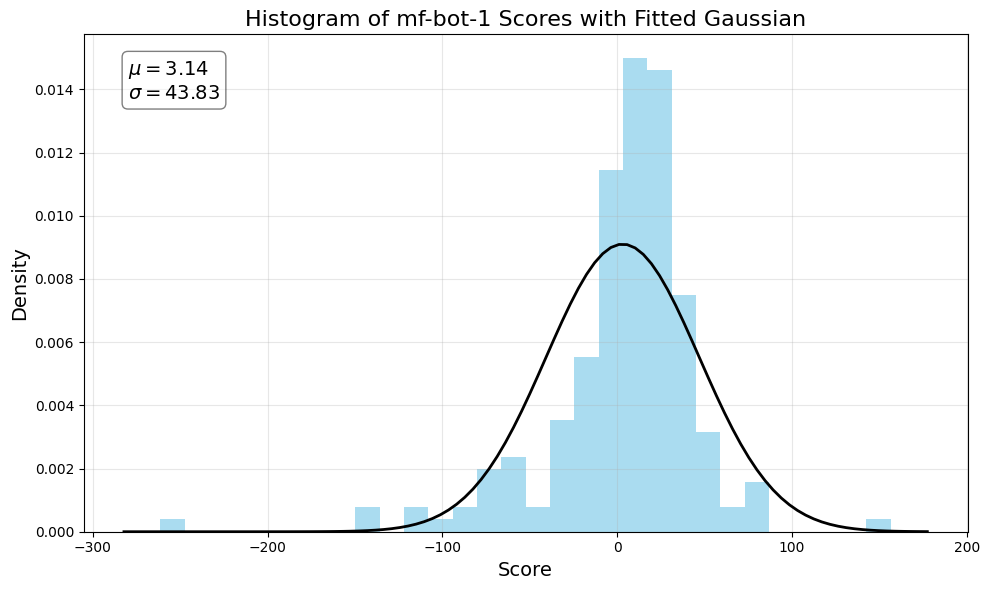

In [33]:
# @title Histogram of bot

# Extract the 'mf-bot-1' column and remove NaN values
#scores = df_bot_vs_pro_peer['FJ_Researcher01+bot'].dropna()

name = 'mf-bot-1'

scores = df_bot_peer_wide[name].dropna()

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(scores, bins=30, density=True, alpha=0.7, color='skyblue')

# Fit a normal distribution to the data
mu, std = norm.fit(scores)

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Customize the plot
plt.title(f"Histogram of {name} Scores with Fitted Gaussian", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add text box with distribution parameters
textstr = f'$\mu={mu:.2f}$\n$\sigma={std:.2f}$'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
# @title Bootstrapping

def weighted_bootstrap_analysis(df_bot_peer_wide, bots, NUM, ITER):
    # Function to perform a single bootstrap iteration
    def single_bootstrap(df):
        # Weighted sampling of questions
        sampled_df = df.sample(n=NUM, weights='question_weight', replace=True)
        # Calculate total weighted score for each bot
        return sampled_df[bots].sum()

    # Perform bootstrap ITER times
    bootstrap_results = [single_bootstrap(df_bot_peer_wide) for _ in range(ITER)]

    # Convert results to DataFrame
    results_df = pd.DataFrame(bootstrap_results)

    # Calculate confidence intervals and median
    ci_low = results_df.quantile(0.025)
    ci_10 = results_df.quantile(0.1)
    ci_high = results_df.quantile(0.975)
    ci_90 = results_df.quantile(0.9)
    median = results_df.median()

    # Create output DataFrame
    output_df = pd.DataFrame({
        '2.5% CI': ci_low,
        '10% CI': ci_10,
        'Median': median,
        '90% CI': ci_90,
        '97.5% CI': ci_high
    })

    # Sort by median descending
    output_df = output_df.sort_values('Median', ascending=False)

    return output_df

NUM = round(df_bot_peer_wide['question_weight'].sum())
ITER = 1000

result_df = weighted_bootstrap_analysis(df_bot_peer_wide, all_bots, NUM, ITER)
average_df = result_df / NUM

print(f'BOT LEADERBOARD\n\n')
df_rounded = average_df.round(1)
df_rounded

BOT LEADERBOARD




,2.5% CI,10% CI,Median,90% CI,97.5% CI
bot_median,8.0,8.6,9.9,11.2,12.0
GreeneiBot2,3.6,5.5,9.0,12.6,14.1
histerio,3.4,5.7,8.9,12.4,14.0
pgodzinai,0.9,3.6,7.8,11.9,13.9
mmBot,1.8,3.9,7.5,11.3,12.8
annabot,2.9,4.1,6.4,8.9,10.0
manticAI,1.1,3.0,6.2,9.7,11.8
mf-bot-4,-2.4,0.4,5.9,10.7,12.9
bestworldbot,-0.7,1.6,5.5,9.6,11.8
mf-bot-5,-1.7,0.3,4.5,8.7,10.7


In [35]:
NUM = round(df_bot_vs_pro_peer['question_weight'].sum())
ITER = 1000

result_df = weighted_bootstrap_analysis(df_bot_vs_pro_peer, all_bots, NUM, ITER)
average_df = result_df / NUM

print(f'\n\n\nHEAD-TO-HEAD LEADERBOARD\n\n')
#df_rounded = result_df.round(0).astype(int)
df_rounded = average_df.round(1)

df_rounded




HEAD-TO-HEAD LEADERBOARD




,2.5% CI,10% CI,Median,90% CI,97.5% CI
MWG,7.1,12.5,29.5,53.6,67.7
bot_median,-16.7,-5.2,19.1,47.2,63.6
pgodzinai,-7.4,-1.5,12.6,32.7,45.3
GreeneiBot2,-10.6,-4.4,11.0,33.4,49.7
silicoqr,1.1,3.7,10.1,18.0,23.8
tombot61,-12.7,-7.1,5.8,24.1,36.7
manticAI,-16.7,-9.9,5.0,27.0,40.1
SaraBase,-23.4,-14.2,4.3,27.2,42.1
predictomatic,-1.5,0.0,3.8,8.7,11.7
histerio,-20.5,-13.4,3.7,25.6,39.3


Weighted score for annabot: 916.5432632126447
Total score for annabot: 1291.2698461207194



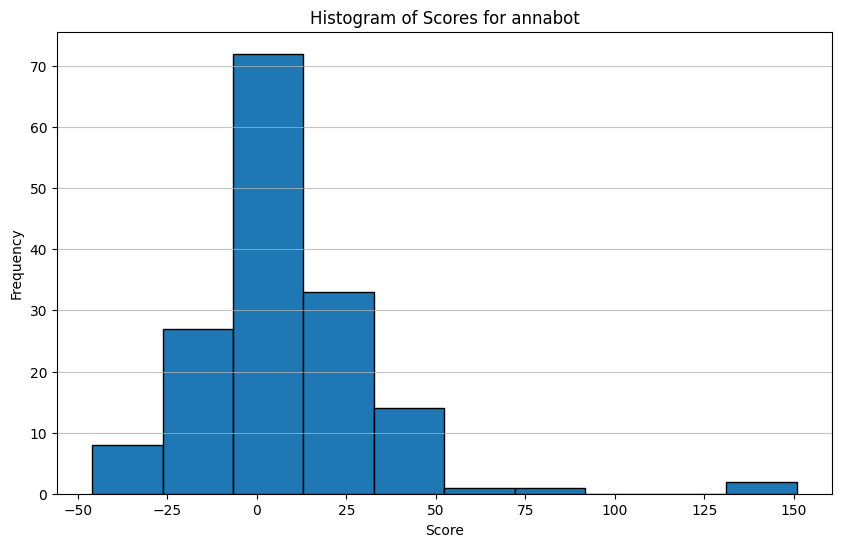

In [36]:
# @title Check specific bot records

bot_name = 'annabot'

df_bot = df_bot_peer_wide[['bot_question_id', 'question_weight', bot_name]]
df_bot = df_bot.dropna()
df_bot = df_bot.reset_index(drop=True)

df_bot['weighted_score'] = df_bot[bot_name] * df_bot['question_weight']

weighted_score = df_bot['weighted_score'].sum()

print(f"Weighted score for {bot_name}: {weighted_score}")

total_score = df_bot[bot_name].sum()

print(f"Total score for {bot_name}: {total_score}\n")

# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(df_bot[bot_name], bins=10, edgecolor='black')

# Customize the plot
plt.title(f'Histogram of Scores for {bot_name}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Add grid lines (optional)
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

In [37]:
# @title Weighted Bot Only Peer, T test

df_W_bot_only_peer_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

# To choose our top bot team, we only use the questions for which there is no Pro benchmark.
no_pro_benchmark = df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['pro_question_id'].isna()]['bot_question_id']

df_bot_only_peer = df_bot_peer[df_bot_peer['bot_question_id'].isin(no_pro_benchmark)]
df_bot_only_peer_wide = make_wide(df_bot_only_peer)

for bot in df_bot_only_peer['forecaster'].unique():

  # T test
  df3 = df_bot_only_peer_wide[[bot, 'question_weight']]
  df3 = df3.dropna()
  df3 = df3.reset_index(drop=True)
  weighted_score = (df3[bot] * df3['question_weight']).sum()
  weighted_count = df3['question_weight'].sum()
  weighted_average = weighted_score / weighted_count
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
  std_error = weighted_std_dev / np.sqrt(weighted_count)
  t_statistic = (weighted_average - 0) / std_error
  if weighted_count > 2:
    t_crit = t_critical_value(weighted_count - 1)
    # 95% confidence that the true mean is between lower and upper bounds
    upper_bound = weighted_average + t_crit * std_error
    lower_bound = weighted_average - t_crit * std_error
    # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
    # Normalization below
    cdf = norm.cdf(t_statistic * 1.96 / t_crit)
  else:
    t_crit = np.nan
    upper_bound = np.nan
    lower_bound = np.nan
    cdf = np.nan

  df_W_bot_only_peer_leaderboard.loc[bot, 'W_score'] = weighted_score
  df_W_bot_only_peer_leaderboard.loc[bot, 'W_count'] = weighted_count
  df_W_bot_only_peer_leaderboard.loc[bot, 'W_ave'] = weighted_average
  df_W_bot_only_peer_leaderboard.loc[bot, 'W_stdev'] = weighted_std_dev
  df_W_bot_only_peer_leaderboard.loc[bot, 'std_err'] = std_error
  df_W_bot_only_peer_leaderboard.loc[bot, 't_stat'] = t_statistic
  df_W_bot_only_peer_leaderboard.loc[bot, 't_crit'] = t_crit
  df_W_bot_only_peer_leaderboard.loc[bot, 'upper_bound'] = upper_bound
  df_W_bot_only_peer_leaderboard.loc[bot, 'lower_bound'] = lower_bound
  df_W_bot_only_peer_leaderboard.loc[bot, 'cdf'] = cdf * 100

df_W_bot_only_peer_leaderboard.sort_values(by='lower_bound', ascending=False)

/tmp/ipykernel_1384382/2492404297.py:22: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
/tmp/ipykernel_1384382/2492404297.py:22: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
/tmp/ipykernel_1384382/2492404297.py:22: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
/tmp/ipykernel_1384382/2492404297.py:22: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
/tmp/ipykernel_1384382/2492404297.py:22: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_d

,W_score,W_count,W_ave,W_stdev,std_err,t_stat,t_crit,upper_bound,lower_bound,cdf
histerio,1127.188212,116.499064,9.675513,33.455869,3.099639,3.121497,1.984,15.825197,3.525830,99.897791
annabot,784.330337,100.499064,7.804355,25.022850,2.496064,3.126664,1.984,12.756546,2.852163,99.899531
mmBot,954.715649,111.499064,8.562544,35.635123,3.374758,2.537232,1.984,15.258064,1.867024,99.390403
pgodzinai,1018.584223,116.499064,8.743282,42.187257,3.908590,2.236941,1.984,16.497924,0.988641,98.644328
GreeneiBot2,815.849526,116.499064,7.003056,33.259069,3.081406,2.272682,1.984,13.116565,0.889548,98.762204
manticAI,760.353092,107.345064,7.083261,33.669445,3.249712,2.179658,1.984,13.530690,0.635832,98.435209
bestworldbot,802.517165,108.999064,7.362606,40.462161,3.875589,1.899739,1.984,15.051774,-0.326562,96.972437
mf-bot-5,636.132350,93.178400,6.827037,40.582846,4.204215,1.623855,1.986,15.176607,-1.522533,94.548812
tombot61,422.283587,54.820664,7.703000,36.776586,4.967058,1.550817,2.006,17.666919,-2.260919,93.514611
acm_bot,299.381315,114.499064,2.614705,32.683574,3.054419,0.856040,1.984,8.674672,-3.445261,80.113573


In [38]:
# Sort the DataFrame by the lower_bound column in descending order
sorted_df = df_W_bot_only_peer_leaderboard.sort_values(by='lower_bound', ascending=False)

# exclude bot median for purposes of bot teaming
sorted_df = sorted_df.drop('bot_median', errors='ignore')

# Get the top 10 bot names
top_10_bots = sorted_df.index[:10].tolist()

# Print the list of top 10 bots
print("Top 10 bots:")
for i, bot in enumerate(top_10_bots, 1):
    print(f"{i}. {bot}")

Top 10 bots:
1. histerio
2. annabot
3. mmBot
4. pgodzinai
5. GreeneiBot2
6. manticAI
7. bestworldbot
8. mf-bot-5
9. tombot61
10. acm_bot


In [39]:
# @title Calculate df_bot_team_forecasts

df_bot_team_forecasts = pd.merge(
    df_bot_forecasts,
    df_pro_bot_resolved_questions[['bot_question_id', 'question_weight', 'resolution']],
    on='bot_question_id',
    how='left'
)

columns_to_keep = ['bot_question_id', 'question_weight', 'resolution'] + top_10_bots

# Filter the DataFrame to keep only the specified columns
df_bot_team_forecasts = df_bot_team_forecasts[columns_to_keep]

#print(df_bot_team_forecasts)

# Function to calculate median forecast for a given number of bots
def calculate_median_forecast(df, bots):
    return df[bots].median(axis=1)

# Calculate and add median forecasts for 2 to 10 bots
for i in range(1, 11):
    bots_subset = top_10_bots[:i]
    column_name = f'median_forecast_{i}_bots'
    df_bot_team_forecasts[column_name] = calculate_median_forecast(df_bot_team_forecasts, bots_subset)

# Display the first few rows of the updated DataFrame
df_bot_team_forecasts.head()

,bot_question_id,question_weight,resolution,histerio,annabot,mmBot,pgodzinai,GreeneiBot2,manticAI,bestworldbot,...,median_forecast_1_bots,median_forecast_2_bots,median_forecast_3_bots,median_forecast_4_bots,median_forecast_5_bots,median_forecast_6_bots,median_forecast_7_bots,median_forecast_8_bots,median_forecast_9_bots,median_forecast_10_bots
0,28857,1.0,no,0.015,NaN,NaN,0.02,0.073333,NaN,0.05,...,0.015,0.01500,0.01500,0.0175,0.0200,0.0200,0.035,0.035,0.0200,0.035
1,28933,1.0,no,0.449,0.6500,NaN,0.75,0.514000,NaN,0.65,...,0.449,0.54950,0.54950,0.6500,0.5820,0.5820,0.650,0.650,0.6500,0.582
2,28935,1.0,no,0.355,0.6275,NaN,0.12,0.356000,NaN,0.67,...,0.355,0.49125,0.49125,0.3550,0.3555,0.3555,0.356,0.356,0.3555,0.355
3,28936,1.0,yes,0.728,0.8375,NaN,0.75,0.666000,NaN,0.85,...,0.728,0.78275,0.78275,0.7500,0.7390,0.7390,0.750,0.750,0.7500,0.750
4,28937,1.0,yes,0.416,0.4000,NaN,0.38,0.508000,NaN,0.70,...,0.416,0.40800,0.40800,0.4000,0.4080,0.4080,0.416,0.416,0.4080,0.416


In [40]:
# @title Calculate the baseline scores for each team size

teams = ['median_forecast_1_bots',
         'median_forecast_2_bots',
         'median_forecast_3_bots',
         'median_forecast_4_bots',
         'median_forecast_5_bots',
         'median_forecast_6_bots',
         'median_forecast_7_bots',
         'median_forecast_8_bots',
         'median_forecast_9_bots',
         'median_forecast_10_bots']

def calculate_weighted_scores(df_bot_team_forecasts, teams):
    # Initialize a dictionary to store the weighted scores for each team
    team_scores = {team: 0 for team in teams}

    # Iterate through each row (question) in the dataframe
    for _, row in df_bot_team_forecasts.iterrows():
        resolution = row['resolution']
        question_weight = row['question_weight']

        # Calculate the baseline score for each team
        for team in teams:
            forecast = row[team]

            # Calculate the baseline score based on the resolution
            if resolution == 'yes':
                baseline_score = np.log2(forecast / 0.5)
            elif resolution == 'no':
                baseline_score = np.log2((1 - forecast) / 0.5)
            else:
                # Skip if resolution is neither 0 nor 1
                continue

            # Calculate the weighted score and add it to the team's total
            weighted_score = baseline_score * question_weight
            team_scores[team] += weighted_score

    # Convert the dictionary to a pandas Series for easier handling
    return pd.Series(team_scores)

weighted_scores = calculate_weighted_scores(df_bot_team_forecasts, teams)
print(weighted_scores)

median_forecast_1_bots     17.296691
median_forecast_2_bots     19.430847
median_forecast_3_bots     18.507514
median_forecast_4_bots     20.618540
median_forecast_5_bots     20.419649
median_forecast_6_bots     21.645484
median_forecast_7_bots     19.783090
median_forecast_8_bots     19.960306
median_forecast_9_bots     20.282635
median_forecast_10_bots    18.968845
dtype: float64


In [41]:
# @title Weighted team-vs-pro

# We have our top bot team members.
# Calculate their median forecast on the pro_bot questions.
# Create df with bot_question_id, forecasts, resolution, weights
# Calculate the head-to-head score

top_bot_team = top_10_bots[:9]
#print(top_bot_team)

df_top_bot_forecasts = df_bot_forecasts[['bot_question_id'] + top_bot_team]
df_top_bot_forecasts['bot_team_median'] = df_top_bot_forecasts[top_bot_team].median(axis=1)
#print(df_top_bot_forecasts)

df_pro_median = df_pro_forecasts[['pro_question_id', 'pro_median']]

df_top_bot_pro_forecasts = pd.merge(
    df_pro_bot_resolved_questions,
    df_top_bot_forecasts[['bot_question_id', 'bot_team_median']],
    on='bot_question_id',
    how='left'
)

df_top_bot_pro_forecasts = pd.merge(
    df_top_bot_pro_forecasts,
    df_pro_median,
    on='pro_question_id',
    how='left'
)

# Filter to only those rows where pro_median is not NA
df_top_bot_pro_forecasts = df_top_bot_pro_forecasts.dropna(subset=['pro_median'])

def calculate_head_to_head(row):
    if row['resolution'] == 'yes':
        return 100* np.log(row['bot_team_median'] / row['pro_median'])
    elif row['resolution'] == 'no':
        return 100* np.log((1 - row['bot_team_median']) / (1 - row['pro_median']))
    else:
        return np.nan

# Add the head_to_head column
df_top_bot_pro_forecasts['head_to_head'] = df_top_bot_pro_forecasts.apply(calculate_head_to_head, axis=1)

df_top_bot_pro_forecasts

/tmp/ipykernel_1384382/3214128128.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_bot_forecasts['bot_team_median'] = df_top_bot_forecasts[top_bot_team].median(axis=1)


,bot_question_id,title,resolution,scheduled_close_time,actual_close_time,pro_question_id,question_weight,bot_team_median,pro_median,head_to_head
5,28959,Will the Liberal Democratic Party win a majori...,no,2024-10-23 14:30:00,2024-10-23 14:30:00,28943,1.0000,0.550000,0.500000,-10.536052
6,28960,Will the Botswana Democratic Party win the 202...,no,2024-10-23 14:30:00,2024-10-23 14:30:00,28944,1.0000,0.700000,0.750000,18.232156
14,29022,Will Intel get dropped from the Dow Jones Indu...,yes,2024-10-24 14:30:00,2024-10-24 14:30:00,28973,1.0000,0.312000,0.259808,18.306175
32,29108,Will any more United Kingdom MPs be suspended ...,yes,2024-10-26 14:30:00,2024-10-26 14:30:00,29053,1.0000,0.680000,0.844985,-21.722632
42,29200,Will a woman be named the Time Person of the Y...,no,2024-10-30 14:30:00,2024-10-30 14:30:00,29181,1.0000,0.265000,0.406003,21.299685
51,29248,"Will Donald Trump says ""win,"" ""won,"" or ""winne...",yes,2024-10-31 14:30:00,2024-10-31 14:30:00,29215,1.0000,0.850000,0.870000,-2.325686
52,29249,Will election night 2024 end without Dave Wass...,no,2024-10-31 14:30:00,2024-10-31 14:30:00,29216,1.0000,0.701250,0.300000,-85.147323
71,29348,[Short fuse] Will California's Proposition 33 ...,no,2024-11-02 14:30:00,2024-11-02 14:30:00,29270,1.0000,0.375000,0.110056,-35.340669
72,29349,"Will it rain more than 100mm in Brasília, Braz...",yes,2024-11-02 14:30:00,2024-11-02 14:30:00,29271,0.5000,0.826250,0.950999,-14.061612
73,29353,Will the US State Department approve more than...,yes,2024-11-02 14:30:00,2024-11-02 14:30:00,29275,0.5000,0.670000,0.995000,-39.546502


In [42]:
# Calculate the weighted score for each row
df_top_bot_pro_forecasts['weighted_score'] = df_top_bot_pro_forecasts['head_to_head'] * df_top_bot_pro_forecasts['question_weight']

# Calculate the total weighted score
total_weighted_score = df_top_bot_pro_forecasts['weighted_score'].sum()

# Calculate the sum of weights
total_weight = df_top_bot_pro_forecasts['question_weight'].sum()

# Calculate the weighted total score
weighted_total_score = total_weighted_score / total_weight

print(f"Weighted Total Score: {weighted_total_score:.4f}")

Weighted Total Score: -7.5944


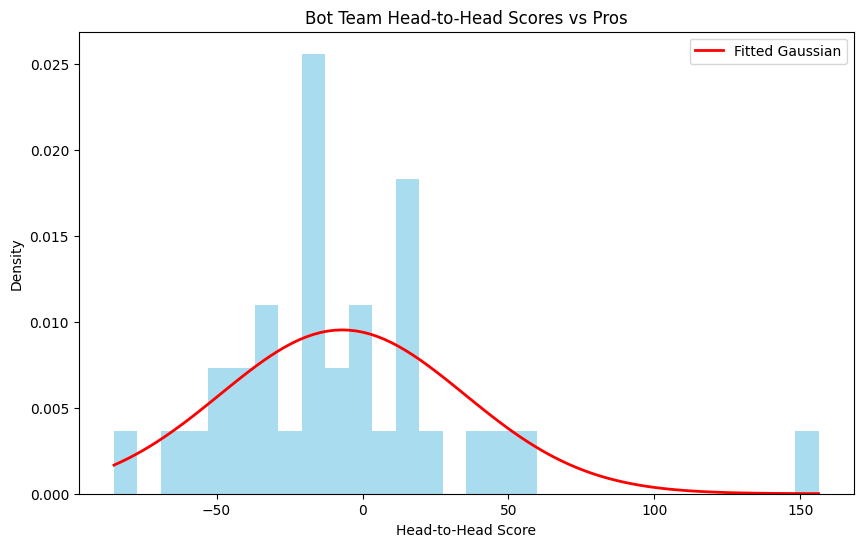

The average of 'head_to_head' is: -6.92


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming df_top_bot_pro_forecasts is already defined and contains the 'head_to_head' column

# Extract the 'head_to_head' data
data = df_top_bot_pro_forecasts['head_to_head']

# Calculate the mean and standard deviation
mean = np.mean(data)
std = np.std(data)

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data, bins=30, density=True, alpha=0.7, color='skyblue')

# Generate points for the fitted Gaussian curve
x = np.linspace(min(data), max(data), 100)
y = norm.pdf(x, mean, std)

# Plot the fitted Gaussian curve
plt.plot(x, y, 'r-', linewidth=2, label='Fitted Gaussian')

# Customize the plot
plt.title('Bot Team Head-to-Head Scores vs Pros')
plt.xlabel('Head-to-Head Score')
plt.ylabel('Density')
plt.legend()

# Add text annotation for the mean
#plt.text(0.95, 0.95, f'Mean: {mean:.2f}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

# Display the plot
plt.show()

# Print the average
print(f"The average of 'head_to_head' is: {mean:.2f}")

In [44]:

df3 = df_top_bot_pro_forecasts.copy()

df3 = df3[['head_to_head', 'question_weight']]
df3 = df3.dropna()
df3 = df3.reset_index(drop=True)
weighted_score = (df3['head_to_head'] * df3['question_weight']).sum()
weighted_count = df3['question_weight'].sum()
weighted_average = weighted_score / weighted_count
weighted_std_dev = np.sqrt(((df3['head_to_head'] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
std_error = weighted_std_dev / np.sqrt(weighted_count)
t_statistic = (weighted_average - 0) / std_error
if weighted_count > 2:
  t_crit = t_critical_value(weighted_count - 1)
  # 95% confidence that the true mean is between lower and upper bounds
  upper_bound = weighted_average + t_crit * std_error
  lower_bound = weighted_average - t_crit * std_error
  # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
  # Normalization below
  cdf = norm.cdf(t_statistic * 1.96 / t_crit)
else:
  t_crit = np.NaN
  upper_bound = np.NaN
  lower_bound = np.NaN
  cdf = np.NaN

df_bot_team_h2h = pd.DataFrame()

df_bot_team_h2h.loc[bot, 'W_score'] = weighted_score
df_bot_team_h2h.loc[bot, 'W_count'] = weighted_count
df_bot_team_h2h.loc[bot, 'W_ave'] = weighted_average
df_bot_team_h2h.loc[bot, 'W_stdev'] = weighted_std_dev
df_bot_team_h2h.loc[bot, 'std_err'] = std_error
df_bot_team_h2h.loc[bot, 't_stat'] = t_statistic
df_bot_team_h2h.loc[bot, 't_crit'] = t_crit
df_bot_team_h2h.loc[bot, 'upper_bound'] = upper_bound
df_bot_team_h2h.loc[bot, 'lower_bound'] = lower_bound
df_bot_team_h2h.loc[bot, 'cdf'] = cdf * 100

print(df_bot_team_h2h)

            W_score  W_count     W_ave    W_stdev   std_err    t_stat  t_crit  \
acm_bot -189.366209  24.9349 -7.594424  39.342498  7.878765 -0.963911   2.064   

         upper_bound  lower_bound        cdf  
acm_bot     8.667346   -23.856194  18.000621  


In [45]:
df_sorted = df_top_bot_pro_forecasts.sort_values(by='head_to_head')

df_top5 = df_sorted.head(5)
df_bottom5 = df_sorted.tail(5)

print("Top 5:")

df_top5[['title', 'bot_team_median', 'pro_median', 'resolution', 'head_to_head']]

Top 5:


,title,bot_team_median,pro_median,resolution,head_to_head
52,Will election night 2024 end without Dave Wass...,0.701250,0.30,no,-85.147323
99,Will 6 or 7 U.S. federal executive department ...,0.483299,0.02,no,-64.008767
100,Will 8 or 9 U.S. federal executive department ...,0.463675,0.05,no,-57.172171
101,Will 10 or 11 U.S. federal executive departmen...,0.478887,0.15,no,-48.926878
143,Will the domestic opening weekend box office r...,0.520125,0.24,no,-45.979278


In [46]:
print("\nBottom 5:")

df_bottom5[['title', 'bot_team_median', 'pro_median', 'resolution', 'head_to_head']]


Bottom 5:


,title,bot_team_median,pro_median,resolution,head_to_head
42,Will a woman be named the Time Person of the Y...,0.265000,0.406003,no,21.299685
176,Will Joe Biden sign 3 or more executive orders...,0.430000,0.300000,yes,36.000273
120,Will the International Criminal Court issue an...,0.327000,0.210000,yes,44.285264
115,Will Lainey Wilson or Luke Combs win the 2024 ...,0.533721,0.740000,no,58.410236
177,Will Joe Biden sign 4 or more executive orders...,0.477000,0.100000,yes,156.234630


In [47]:
# Cast df_top_bot_pro_forecasts['resolution'] as string - idk why this is necessary but it is
df_top_bot_pro_forecasts['resolution'] = df_top_bot_pro_forecasts['resolution'].astype(pd.StringDtype())
df_top_bot_pro_forecasts['resolution'] = df_top_bot_pro_forecasts['resolution'].map({'yes': 1, 'no': 0})
df_top_bot_pro_forecasts.dtypes

bot_question_id                  Int64
title                           object
resolution                       int64
scheduled_close_time    datetime64[ns]
actual_close_time       datetime64[ns]
pro_question_id                  Int64
question_weight                float64
bot_team_median                float64
pro_median                     float64
head_to_head                   float64
weighted_score                 float64
dtype: object

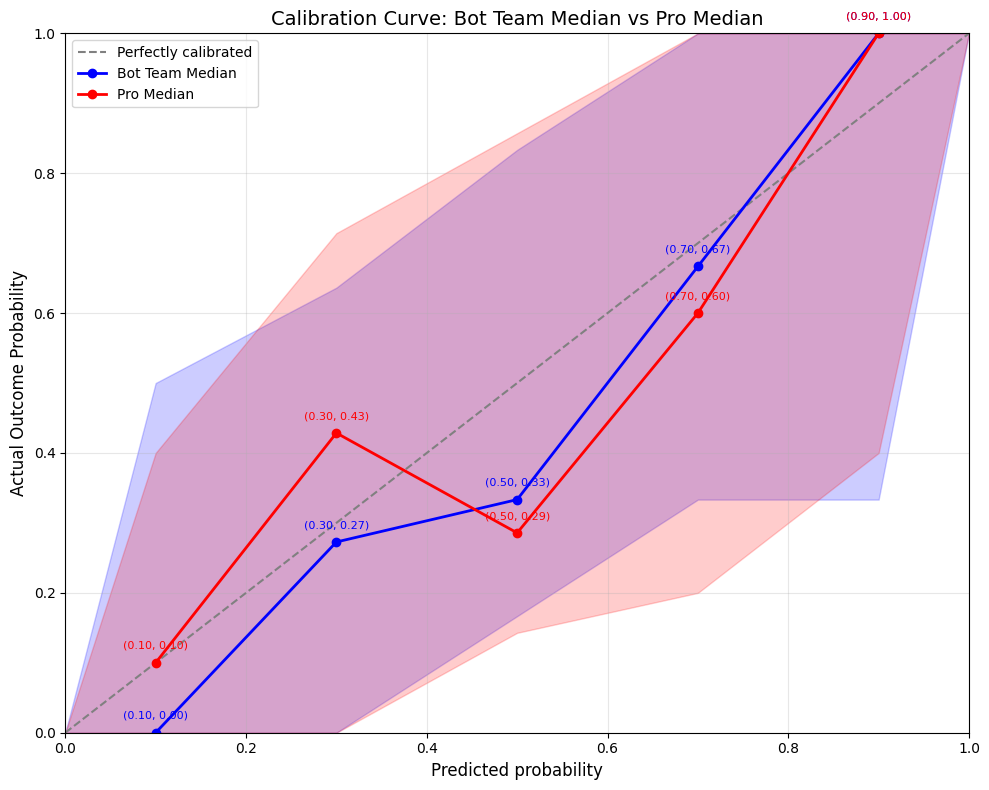

Number of pro forecasts: 34
Number of bot forecasts: 183


In [67]:
from scipy.stats import binom


def caculate_calibration_curve(forecasts: list[float], resolutions: list[int], weights: list[float]) -> dict:
    calibration_curve = []
    bin_size = 0.2  # Single consistent bin size
    bins = [(0.0,0.0)]
    bins.extend([(i * bin_size, (i + 1) * bin_size) for i in range(int(1/bin_size))])
    bins.append((1.0, 1.0))
    for p_min, p_max in bins:
        resolutions_for_bucket = []
        weights_for_bucket = []
        bin_center = (p_min + p_max) / 2
        for value, weight, resolution in zip(forecasts, weights, resolutions):
            if p_min <= value < p_max:
                resolutions_for_bucket.append(resolution)
                weights_for_bucket.append(weight)
        count = max(len(resolutions_for_bucket), 1)
        average_resolution = (
            np.average(resolutions_for_bucket, weights=weights_for_bucket)
            if sum(weights_for_bucket) > 0
            else None
        )
        lower_confidence_interval = binom.ppf(0.05, count, p_min) / count
        perfect_calibration = binom.ppf(0.50, count, bin_center) / count
        upper_confidence_interval = binom.ppf(0.95, count, p_max) / count

        calibration_curve.append(
            {
                "bin_lower": p_min,
                "bin_upper": p_max,
                "lower_confidence_interval": lower_confidence_interval,
                "average_resolution": average_resolution,
                "upper_confidence_interval": upper_confidence_interval,
                "perfect_calibration": perfect_calibration,
            }
        )

    return {
        "calibration_curve": calibration_curve,
    }


def plot_calibration_curve(df, column_name, label, color):
    y_true = df['resolution']
    y_pred = df[column_name]
    weights = [1.0 for _ in y_true]
    calibration_curve = caculate_calibration_curve(y_pred, y_true, weights)['calibration_curve']
    prob_true = [item['average_resolution'] for item in calibration_curve]
    bin_center = [(item['bin_lower'] + item['bin_upper']) / 2 for item in calibration_curve]
    ci_lower = [item['lower_confidence_interval'] for item in calibration_curve]
    ci_upper = [item['upper_confidence_interval'] for item in calibration_curve]

    plt.plot(bin_center, prob_true, marker='o', linewidth=2, label=label, color=color)
    plt.fill_between(bin_center, ci_lower, ci_upper, alpha=0.2, color=color)
    for x, y in zip(bin_center, prob_true):
        if x is None or y is None:
            continue
        plt.annotate(f'({x:.2f}, {y:.2f})',
                    (x, y),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    color=color,
                    fontsize=8)


# Set up the plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Plot calibration curves for bot_team_median and pro_median
plot_calibration_curve(df_top_bot_pro_forecasts, 'bot_team_median', 'Bot Team Median', 'blue')
plot_calibration_curve(df_top_bot_pro_forecasts, 'pro_median', 'Pro Median', 'red')

# Customize the plot
plt.xlabel('Predicted probability', fontsize=12)
plt.ylabel('Actual Outcome Probability', fontsize=12)
plt.title('Calibration Curve: Bot Team Median vs Pro Median', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()
print(f"Number of pro forecasts: {len(df_top_bot_pro_forecasts)}")
print(f"Number of bot forecasts: {len(df_bot_forecasts)}")

In [49]:
import numpy as np
import pandas as pd

# Assuming df_top_bot_pro_forecasts is already defined

def calculate_confidence(predictions, outcomes):
    """
    Calculate over- or under-confidence for a set of predictions.

    :param predictions: Series of predicted probabilities
    :param outcomes: Series of actual outcomes (0 or 1)
    :return: Confidence score (positive for overconfidence, negative for underconfidence)
    """
    # Bin predictions into 10 equally spaced bins
    bins = pd.cut(predictions, bins=10)

    # Calculate mean prediction and actual outcome for each bin
    grouped = pd.DataFrame({'prediction': predictions, 'outcome': outcomes}).groupby(bins)
    mean_prediction = grouped['prediction'].mean()
    mean_outcome = grouped['outcome'].mean()

    # Calculate the difference between mean prediction and mean outcome
    confidence_diff = mean_prediction - mean_outcome

    # Return the average difference (excluding NaN values)
    return np.nanmean(confidence_diff)

# Calculate confidence scores for bot_team_median and pro_median
bot_confidence = calculate_confidence(df_top_bot_pro_forecasts['bot_team_median'], df_top_bot_pro_forecasts['resolution'])
pro_confidence = calculate_confidence(df_top_bot_pro_forecasts['pro_median'], df_top_bot_pro_forecasts['resolution'])

print(f"Bot team confidence score: {bot_confidence:.4f}")
print(f"Pro team confidence score: {pro_confidence:.4f}")

# Interpret the results
def interpret_confidence(score):
    if score > 0:
        return f"Overconfident by {score:.4f}"
    elif score < 0:
        return f"Underconfident by {abs(score):.4f}"
    else:
        return "Perfectly calibrated"

print(f"Bot team is {interpret_confidence(bot_confidence)}")
print(f"Pro team is {interpret_confidence(pro_confidence)}")

Bot team confidence score: 0.0165
Pro team confidence score: 0.0047
Bot team is Overconfident by 0.0165
Pro team is Overconfident by 0.0047


/tmp/ipykernel_1319090/3215770322.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pd.DataFrame({'prediction': predictions, 'outcome': outcomes}).groupby(bins)


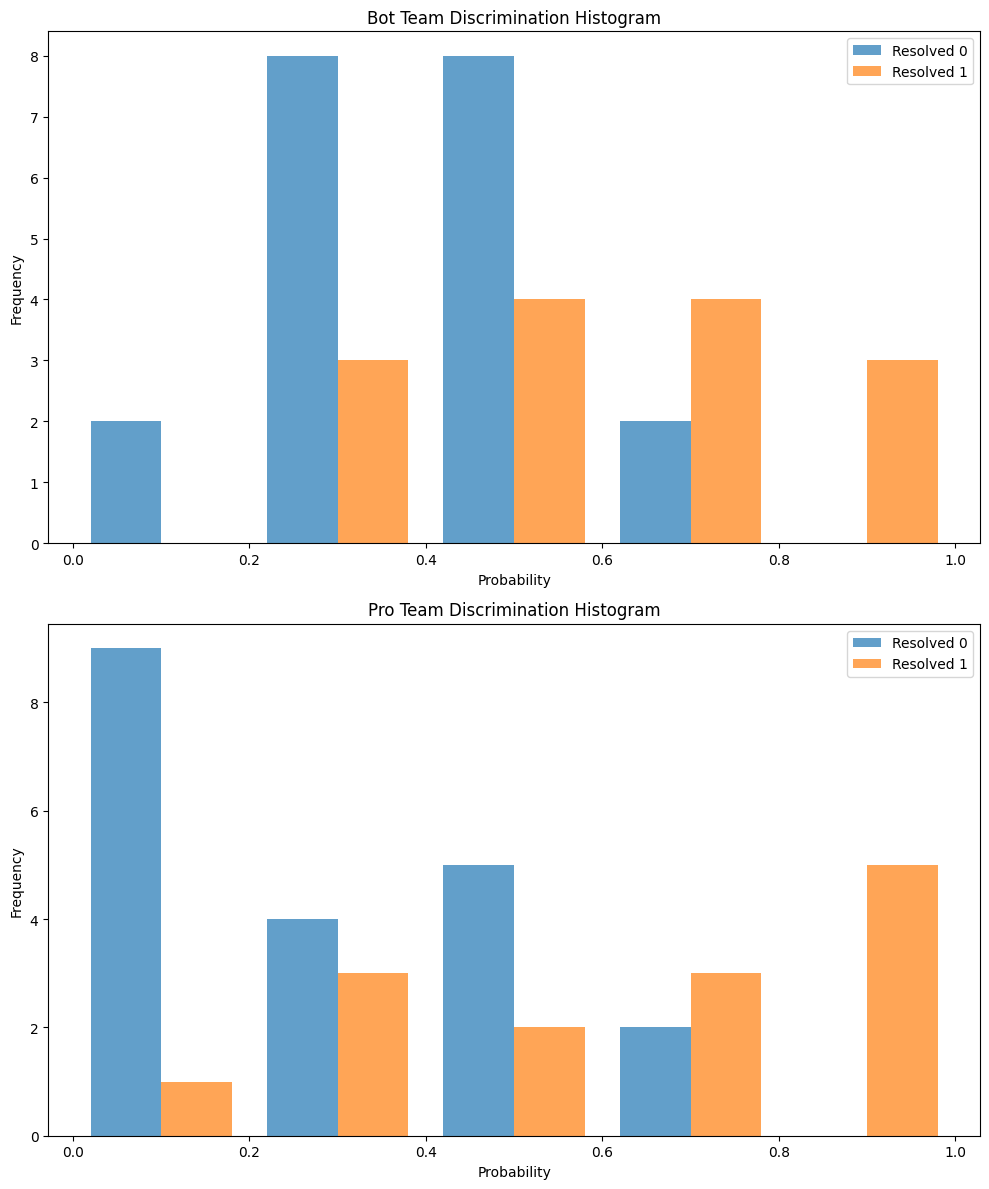

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_top_bot_pro_forecasts is already loaded
# If not, you would load it here:
# df_top_bot_pro_forecasts = pd.read_csv('your_data.csv')

def create_discrimination_histogram(df, bot_col, pro_col, resolution_col):
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Define bin edges
    #bins = np.linspace(0, 1, 11)
    bins = np.linspace(0, 1, 6)

    # Bot team histogram
    ax1.hist([df[df[resolution_col] == 0][bot_col],
              df[df[resolution_col] == 1][bot_col]],
             bins=bins, label=['Resolved 0', 'Resolved 1'], alpha=0.7)
    ax1.set_title('Bot Team Discrimination Histogram')
    ax1.set_xlabel('Probability')
    ax1.set_ylabel('Frequency')
    ax1.legend()

    # Pro team histogram
    ax2.hist([df[df[resolution_col] == 0][pro_col],
              df[df[resolution_col] == 1][pro_col]],
             bins=bins, label=['Resolved 0', 'Resolved 1'], alpha=0.7)
    ax2.set_title('Pro Team Discrimination Histogram')
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Frequency')
    ax2.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame and column names
create_discrimination_histogram(df_top_bot_pro_forecasts,
                                'bot_team_median',
                                'pro_median',
                                'resolution')

In [51]:

# Calculate average forecasts for resolved 1 and 0 for bots
bot_avg_1 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 1]['bot_team_median'].mean()
bot_avg_0 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 0]['bot_team_median'].mean()

# Calculate average forecasts for resolved 1 and 0 for pros
pro_avg_1 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 1]['pro_median'].mean()
pro_avg_0 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 0]['pro_median'].mean()

# Calculate the differences
bot_difference = bot_avg_1 - bot_avg_0
pro_difference = pro_avg_1 - pro_avg_0

print(f"Bot average forecast difference (1 - 0): {bot_difference:.4f}")
print(f"Pro average forecast difference (1 - 0): {pro_difference:.4f}")

# Calculate the difference between pro and bot differences
pro_bot_difference = pro_difference - bot_difference
print(f"Difference between pro and bot differences: {pro_bot_difference:.4f}")

Bot average forecast difference (1 - 0): 0.1831
Pro average forecast difference (1 - 0): 0.3337
Difference between pro and bot differences: 0.1507


In [52]:
# TK: Ask Tom for scope sensitivity questions?

# Assuming df_top_bot_pro_forecasts is already loaded

if False:

    def get_forecast(question_id):
        forecast = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['bot_question_id'] == question_id]['bot_team_median'].values
        return forecast[0] if len(forecast) > 0 else np.nan

    def process_scope_questions(bot_scope_questions):
        scope_ratios = []

        for question_tuple in bot_scope_questions:
            forecasts = [get_forecast(qid) for qid in question_tuple]

            print(f"Forecasts for questions {question_tuple}: {forecasts}")

            if not any(np.isnan(forecasts)):
                scope_ratio = forecasts[0] / (forecasts[1] + forecasts[2])
                print(f"Scope ratio: {scope_ratio:.4f}")
                scope_ratios.append(scope_ratio)
            else:
                print("Unable to calculate scope ratio due to missing forecast(s)")

            print()  # Empty line for readability

        return scope_ratios

    # Process the bot_scope_questions
    scope_ratios = process_scope_questions(bot_scope_questions)

    # Calculate and print the average scope ratio
    if scope_ratios:
        average_scope_ratio = sum(scope_ratios) / len(scope_ratios)
        print(f"Average scope ratio: {average_scope_ratio:.4f}")
    else:
        print("No valid scope ratios to average")

In [53]:
# Calculate weighted number of 1 resolutions
weighted_ones = np.sum(
    df_top_bot_pro_forecasts['resolution'] *
    df_top_bot_pro_forecasts['question_weight']
)

# Calculate weighted number of 0 resolutions
weighted_zeros = np.sum(
    (1 - df_top_bot_pro_forecasts['resolution']) *
    df_top_bot_pro_forecasts['question_weight']
)

print(f"Weighted number of 1 resolutions: {weighted_ones}")
print(f"Weighted number of 0 resolutions: {weighted_zeros}")

print(f"Average 1 resolutions: {weighted_ones / (weighted_zeros + weighted_ones)}")

Weighted number of 1 resolutions: 9.9294
Weighted number of 0 resolutions: 15.005500000000001
Average 1 resolutions: 0.3982129465127191
